In [4]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

Imports necessary libraries:
pandas: data manipulation, read the dataset
torch(pytorch): tensor operations and implementing K-Means
matplotlib.pyplot and seaborn: plotting graphs and data visualization
silhouette_score from sklearn.metrics: calculate silhouette scores to find optimal number of cluster
PCA from sklearn.decomposition: perform PCA to visualize clusters in 2D dimensions.

In [5]:
# read dataset
columns = [
    "Recency (months)",
    "Frequency (times)",
    "Monetary (c.c. blood)",
    "Time (months)",
    "Target",  # "whether he/she donated blood in March 2007"
]
data = pd.read_csv("transfusion.data", names=columns, skiprows=1)

Data Reading: dataset is loaded into a pandas DataFrame with predefined column names and skips the first row which is be a header row

In [6]:
# drop target column to get only features
features = data.drop(columns=["Target"])

Feature Selection: The target column is dropped to only get the features columns

In [7]:
# convert to pytorch tensors
feature_tensor = torch.tensor(features.values, dtype=torch.float32)

Tensor Conversion: convert the feature data into PyTorch tensors for numerical operations

In [8]:
# min-max scaling normalization
feature_min_values = feature_tensor.min(dim=0, keepdim=True).values
feature_max_values = feature_tensor.max(dim=0, keepdim=True).values
# features will have values range from 0 to 1
features_normalized = (feature_tensor - feature_min_values) / (
    feature_max_values - feature_min_values
)

Normalization: use min-max scaling to normalize feature values, all values are within the range from 0 to 1, it helps prevent single feature domination

In [9]:
# K-Means function
def k_means(normalized_features, clusters, iterations=50):
    # initialize centroids randomly
    centroids = normalized_features[
        torch.randperm(normalized_features.size(0))[:clusters]
    ]

    for _ in range(iterations):
        # calculate distances from data points to centroids
        distances = torch.cdist(normalized_features, centroids)

        # assign data point to nearest centroid
        labels = torch.argmin(distances, dim=1)

        for i in range(clusters):
            if torch.sum(labels == i) > 0:
                # assign centroid to the mean of data points and update centroid
                centroids[i] = normalized_features[labels == i].mean(dim=0)

    return labels, centroids

K-Means implementation:
The function initializes cluster centroids randomly from normalized features
Calculate distance: For each iteration, it calculates the distance between each data point and all centroids using torch.cdist
Each data point is assigned to the nearest centroid based on distances
Update Centroid: For each cluster, if there are points assigned to it, the centroid is updated to be the mean of all points assigned to the cluster
The function returns the final cluster labels and centroids

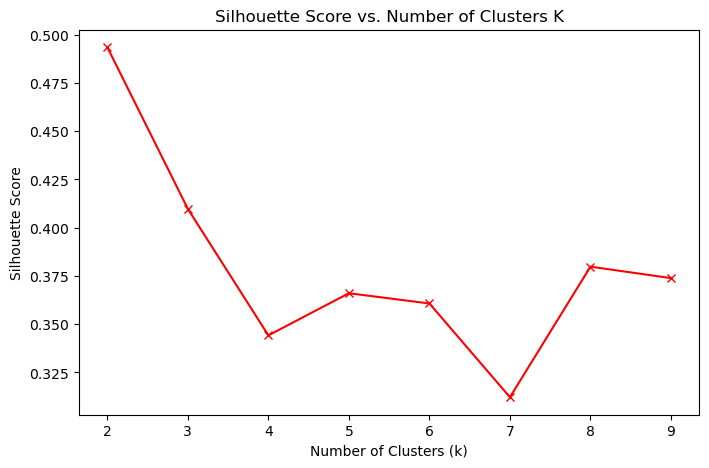

Optimal number of cluster is: 2



In [10]:
# Compute Silhouette Scores from 2 to 9 to find the optimal cluster K
silhouette_scores = []
for k in range(2, 10):
    cluster_labels, _ = k_means(features_normalized, k, 50)
    # use silhouette_score func from scikit-learn
    score = silhouette_score(features_normalized.numpy(), cluster_labels.numpy())
    silhouette_scores.append(score)

# Optimal number of clusters will have highest silhouette score
# get index and plus 2 because we start at index 0 with value K=2
optimal_cluster = silhouette_scores.index(max(silhouette_scores)) + 2

# Silhouette score plot
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_scores, "rx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters K")
plt.show()
print(f"Optimal number of cluster is: {optimal_cluster}\n")

The silhouette score interpretation measures the quality of k-means silhouette score by measures how well objects group within their assigned clusters compared other clusters.
Calculation: the loop calculates the silhouette score for different numbers of clusters (from 2 to 9) with help of silhouette_score func from scikit-learn
The optimal number of clusters is determined by finding the index of the maximum silhouette score. Since we started counting clusters from 2, we add 2 to the index to get the correct number of clusters
Then create a plot to visualize silhouette score better changes with the number of clusters

In [11]:
# run k-means algorithm with optimal cluster
cluster_labels, centroids = k_means(features_normalized, optimal_cluster)

# Add column Cluster to the original dataset
data["Cluster"] = cluster_labels.numpy()

Call k_means func to run the K-Means algorithm with the optimal number of clusters found above
The result cluster labels are added as a column in the original dataset for visualization

Some diagrams to help to understand the data and the clusters.



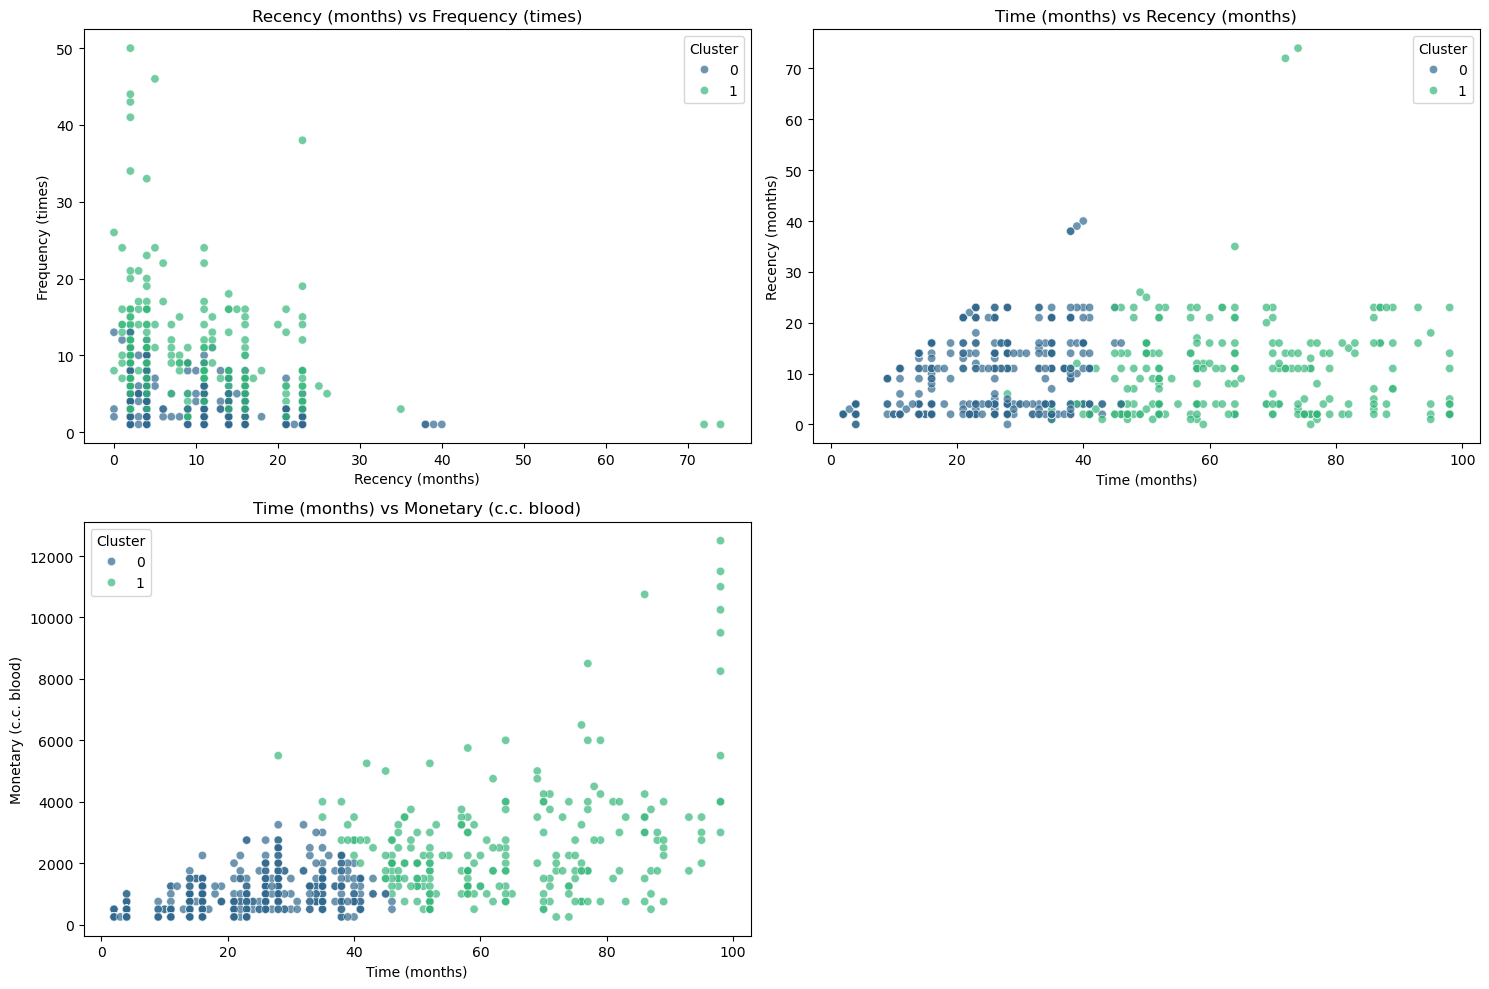

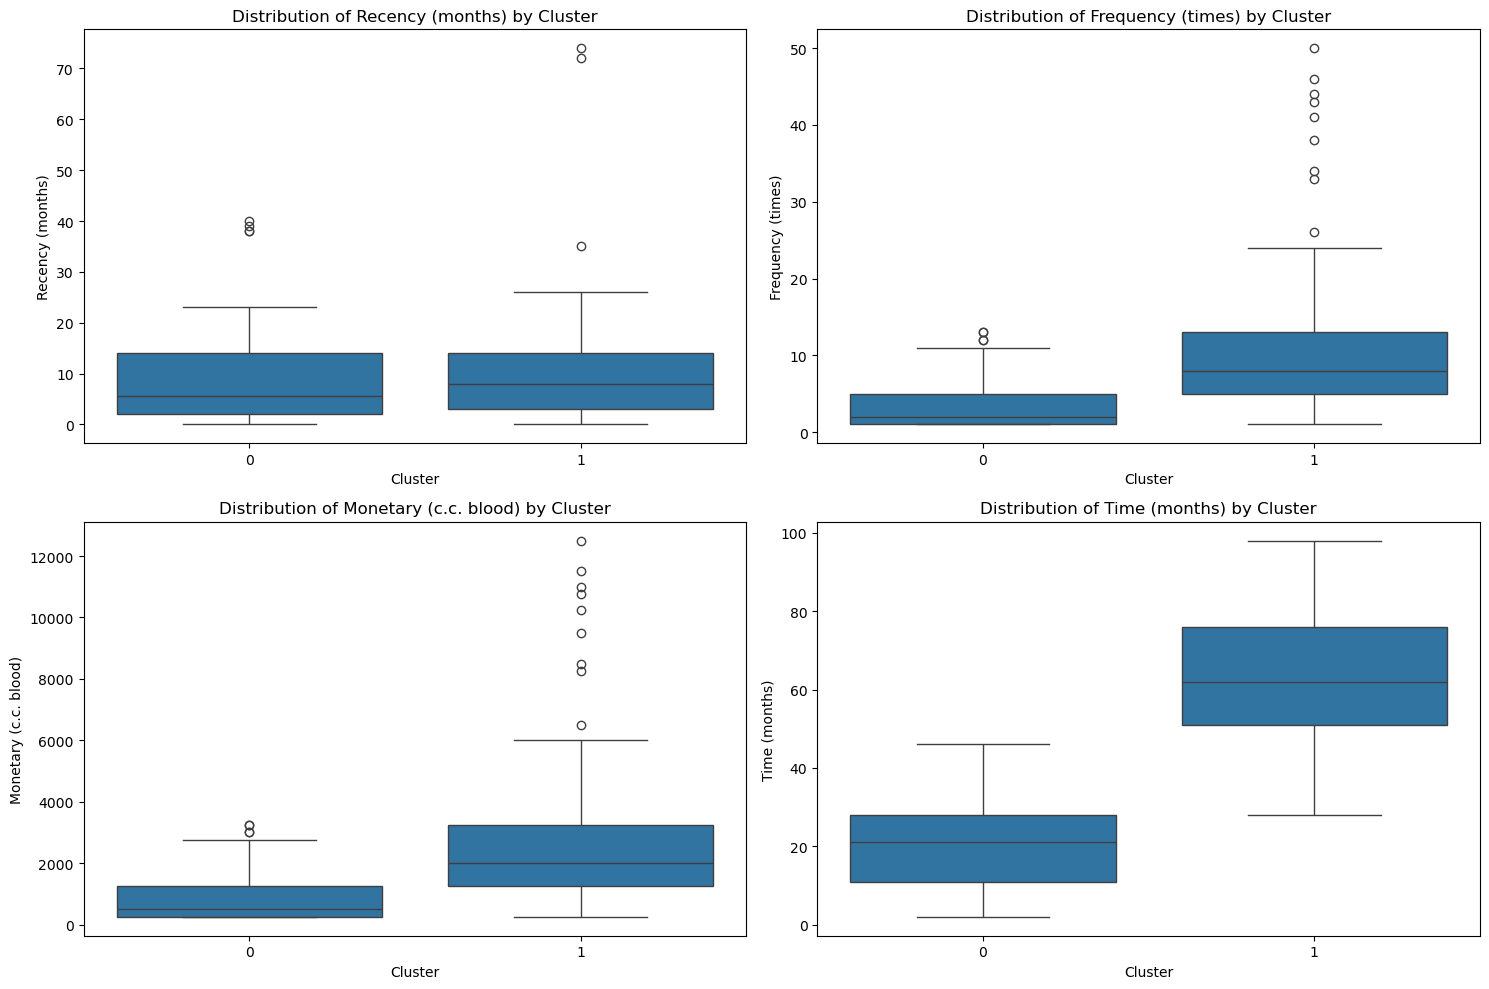

In [12]:
# Visualization
print("Some diagrams to help to understand the data and the clusters.\n")
# scatter plots for features pair
feature_pairs = [
    ("Recency (months)", "Frequency (times)"),
    ("Time (months)", "Recency (months)"),
    ("Time (months)", "Monetary (c.c. blood)"),
]

plt.figure(figsize=(15, 10))
for i, (x_feature, y_feature) in enumerate(feature_pairs, start=1):
    plt.subplot(2, 2, i)
    sns.scatterplot(
        x=features[x_feature],
        y=features[y_feature],
        hue=data["Cluster"],
        palette="viridis",
        alpha=0.7,
    )
    plt.title(f"{x_feature} vs {y_feature}")
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.legend(title="Cluster")
plt.tight_layout()

# feature distributions by cluster
plt.figure(figsize=(15, 10))
# skip Target and Cluster column
for i, col in enumerate(data.columns[:-2], start=1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="Cluster", y=col, data=data)
    plt.title(f"Distribution of {col} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(col)
plt.tight_layout()

Visualization with scatter plots and box plots to show relationships between pairs of features and their correlation within cluster; and box plots help to provide information into how donor behaviors differ between clusters
These visualizations are created using the seaborn and matplotlib libraries, with appropriate figure sizes, titles, and labels for clarity.

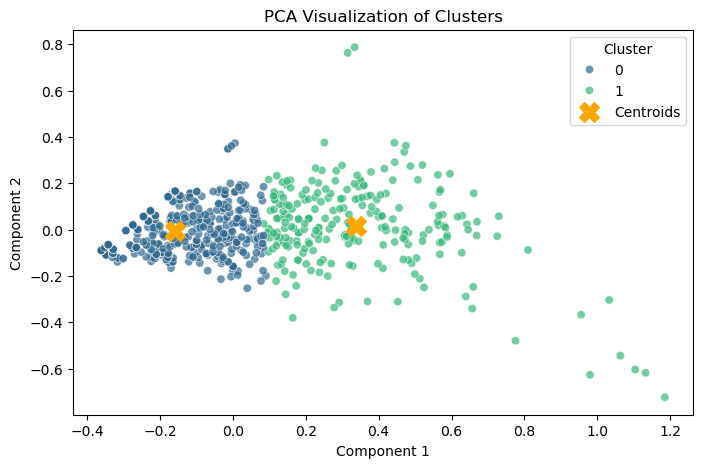

In [13]:
# PCA - Principal Component Analysis
# visualize in 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_normalized.numpy())
reduced_centroids = pca.transform(centroids.numpy())
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=cluster_labels.numpy(),
    palette="viridis",
    alpha=0.7,
)
plt.scatter(
    reduced_centroids[:, 0],
    reduced_centroids[:, 1],
    c="orange",
    marker="X",
    s=200,
    label="Centroids",
)
plt.title("PCA Visualization of Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster")
plt.show()

Using PCA from scikit-learn, the dataset's dimensionality is reduced to 2D for visualization. 
The plot helps to verify whether K-Means successfully grouped donors with similar patterns into clusters.